# Sensor space analysis: Time domain analysis (ERP/ERF) in MNE-Python

`
Authors:
Britta Westner, Alexandre Gramfort, Denis A. Engemann
`

## Setup

We already know this part from last time:
 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mne

mne.set_log_level('error')

## Set the path to the data and load the previously saved epochs

You should have downloaded the `ds000117-practical` folder. We have to let Python know, where to find this folder on your disk. You will have to adjust the path below to reflect your computer and path structure!
You can print the whole path and check the directory to double check it's correct.

In [2]:
# Change the following path to where the folder ds000117 is on your disk
data_path = os.path.expanduser("~/Documents/teaching/practical_meeg_2022_data/ds000117")

epochs_fname = os.path.join(data_path,
    'derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-epo.fif')

In [3]:
epochs = mne.read_epochs(epochs_fname, proj=False)

In [4]:
epochs.info

<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG, 2 EOG
 custom_ref_applied: True
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 378
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: EOG-planar--0.200-0.200-PCA-01: off, EOG-axial-- ...
 sfreq: 300.0 Hz
 subject_info: 2 items (dict)
>

Wait, why are the projections "on"? We did not apply them before saving - can you find out why the seem to be applied now?

## Explore the different conditions in the data

We have seen in the last session, that the data has different events, which mark which stimulus was shown to the participants. The event/trigger structure is as follows:
- 5, 6, 7: famous faces
- 13, 14, 15: unfamiliar faces
- 17, 18, 19: scrambled faces

We have epoched the data according to these events previously. Let's see how we can use these event codes to work with the conditions!

We first look at how we registered the events:

In [5]:
epochs

Number of events,145
Events,face/famous/first: 24face/famous/immediate: 10face/famous/long: 14face/unfamiliar/first: 25face/unfamiliar/immediate: 12face/unfamiliar/long: 10scrambled/first: 25scrambled/immediate: 14scrambled/long: 11
Time range,-0.500 – 2.000 sec
Baseline,-0.200 – 0.000 sec


We can now query the data based on the event IDs:

In [6]:
epochs['long']

Number of events,35
Events,face/famous/long: 14face/unfamiliar/long: 10scrambled/long: 11
Time range,-0.500 – 2.000 sec
Baseline,-0.200 – 0.000 sec


In [7]:
epochs['scrambled', 'famous']

Number of events,98
Events,face/famous/first: 24face/famous/immediate: 10face/famous/long: 14scrambled/first: 25scrambled/immediate: 14scrambled/long: 11
Time range,-0.500 – 2.000 sec
Baseline,-0.200 – 0.000 sec


In [8]:
epochs['famous']

Number of events,48
Events,face/famous/first: 24face/famous/immediate: 10face/famous/long: 14
Time range,-0.500 – 2.000 sec
Baseline,-0.200 – 0.000 sec


We can now for example use this for plotting the epochs based on condition:

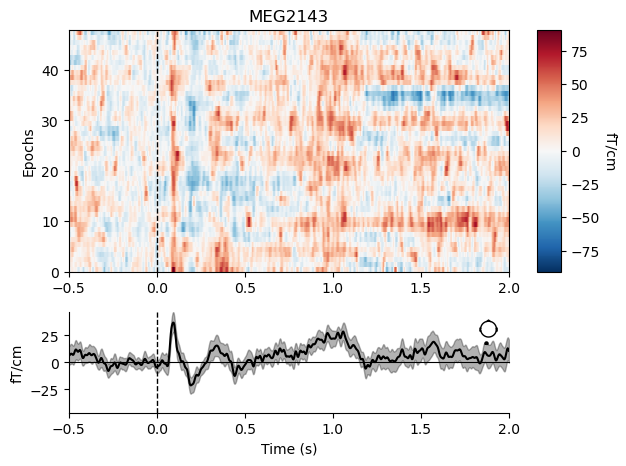

In [9]:
epochs['famous'].plot_image(picks='MEG2143', sigma=1.);

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Can you make the same plot for the other two conditions?</li>
      <li>Is there anything you notice?</li>   
    </ul>
</div>

## Average the epochs to get ERF/ERP 

In [10]:
evoked = epochs.average()
evoked.apply_proj();

In [11]:
evoked.info

<Info | 25 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 70 EEG
 custom_ref_applied: True
 description: (meg) Vectorview system at Cambridge
 dev_head_t: MEG device -> head transform
 dig: 137 items (3 Cardinal, 5 HPI, 75 EEG, 54 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 40.0 Hz
 meas_date: 1941-03-22 11:04:14 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: dgw_studies
 projs: EOG-planar--0.200-0.200-PCA-01: on, EOG-axial-- ...
 sfreq: 300.0 Hz
 subject_info: 2 items (dict)
>

Let's look at our evoked field and evoked potential!

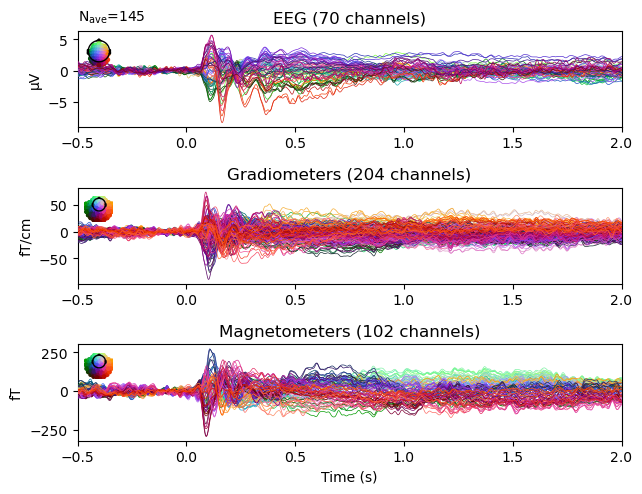

In [12]:
evoked.plot();

## Separate the conditions

Let's look at the ERP at channel EEG065 for all three conditions.

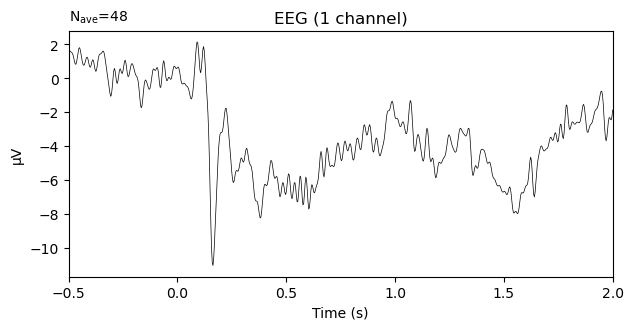

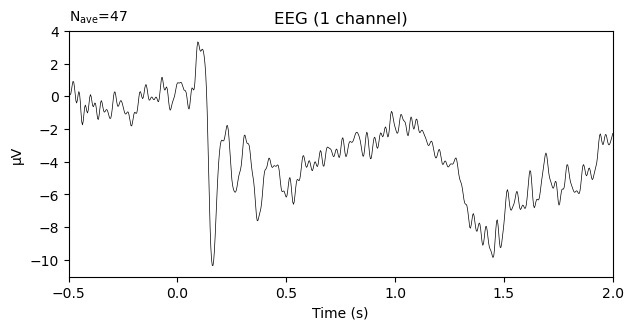

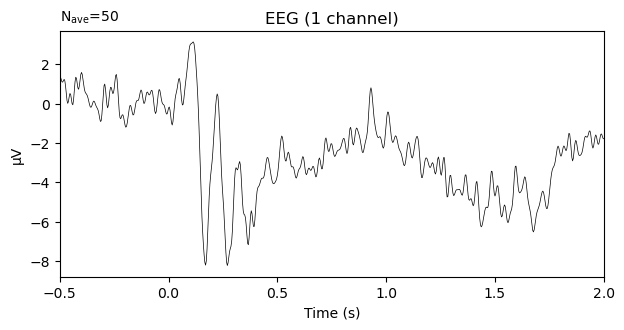

In [13]:
# Remember how we can index the epochs:
for condition in ['famous', 'unfamiliar', 'scrambled']:
    epochs[condition].average().plot(picks='EEG065');

To more easily handle our evoked object, let's make a _list of evoked objects_ for the different conditions we are interested in. Then we can also make it easier for ourselved and compare the ERPs in one plot!

In [14]:
conditions = ['famous', 'unfamiliar', 'scrambled']
evokeds_list = []
for k, cond in enumerate(conditions):
   evokeds_list.append(epochs[cond].average().apply_proj().crop(-0.5, 1))
   evokeds_list[k].comment = cond  # we want to update the name of the condition for plotting

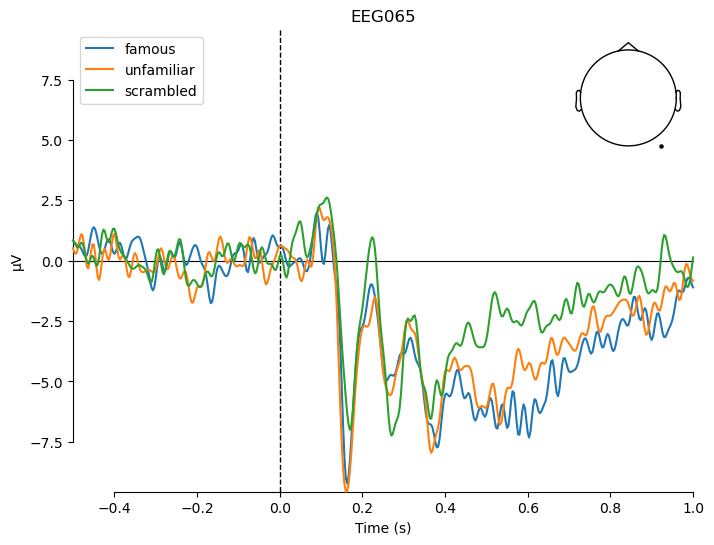

In [15]:
mne.viz.plot_compare_evokeds(evokeds_list, picks='EEG065');

But what if we want to see _all_ channels?

In [16]:
%matplotlib qt
mne.viz.plot_compare_evokeds(evokeds_list, picks='meg', axes='topo');

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Try clicking on the plot, what happens?</li>
      <li>Can you make the same plots for magnetometers and gradiometers?</li>
    </ul>
</div>


## Plot standard deviation across trials

It can be helpful to visualize evoked data with confidence intervals or standard deviations. Let's see how!

For standard deviations across _trials_, there is no ready-to-use MNE-Python function. The reason: Evoked objects do not store the information to compute this metric (i.e., single trials) anymore!

But don't worry: we can plot this ourselves using matplotlib - and gain some knowledge about matplotlib and writing functions on the way!

In [17]:
# Let's write our own function to compute the standard deviations!
# Since we have to use this operation for each condition, it's handy to write a function for it:

# Everything we need within the function, we have to pass to the function.
# In this case, we need the epochs object, and we want to pick this object for the right condition
# and for channels, so we also pass condition and picks.
def compute_sd(epochs, condition, picks):
    """ Get CI from epochs object for condition."""

    # this gets the data for the condition and channel as an array:
    epochs_data = epochs[condition].get_data(picks=picks)

    # compute the mean first
    epochs_mean = np.mean(epochs_data, axis=0)

    # compute the standard deviation
    epochs_std = np.std(epochs_data, axis=0)

    # add above and below the mean:
    sd_upper = np.squeeze(epochs_mean + epochs_std)
    sd_lower = np.squeeze(epochs_mean - epochs_std)

    # and return what we need
    return sd_lower, sd_upper    


In [18]:
# we have cropped the evoked, so we also have to crop the epochs!
epochs_crop = epochs.copy().crop(-0.5, 1)

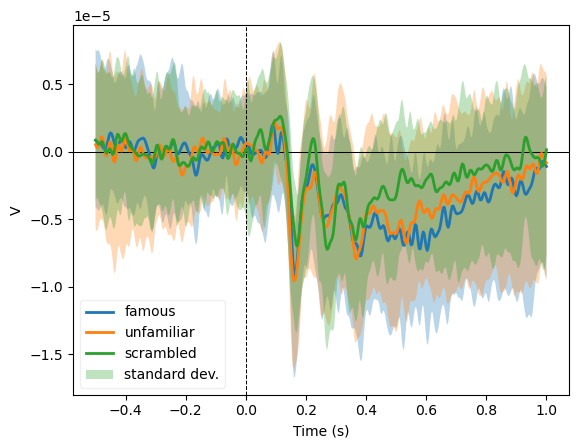

In [19]:
%matplotlib inline

picks = 'EEG065'  # we plot one channel

# let's first add the lines at zero that MNE-Python has
plt.axhline(y=0., color='black', linewidth=0.75)
plt.axvline(x=0., color='black', linewidth=0.75, linestyle='--')

for ii, condition in enumerate(conditions):

    # first let's compute the standard deviation with our function
    sd_lower, sd_upper = compute_sd(epochs_crop, condition, picks)

    # get the evoked data from the evokeds list
    evoked_data = evokeds_list[ii].get_data(picks=picks)
    times = evokeds_list[ii].times

    # plot the evoked
    plt.plot(times, np.squeeze(evoked_data), linewidth=2, label=condition)

    # plot the standard deviation and add a label once
    plt.fill_between(times, sd_lower, sd_upper, alpha=0.3,
                     label=('standard dev.' if ii==2 else None))



# labels and legend 
plt.ylabel('V')  # note the difference in scaling to MNE-Python!
plt.xlabel('Time (s)')
plt.legend(loc='lower left', framealpha=0.3)

plt.show()


## Plot topographies

Next, we want to plot the topographies at the peak. For that, we first have to find the peak time!

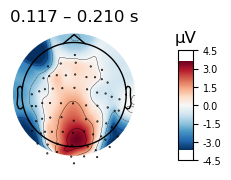

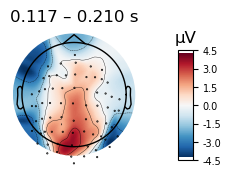

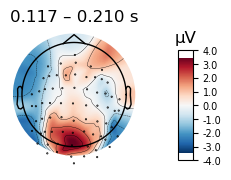

In [32]:
for ii, cond in enumerate(conditions):
        evokeds_list[ii].plot_topomap(
            ch_type='eeg', times=0.163, average=0.1)


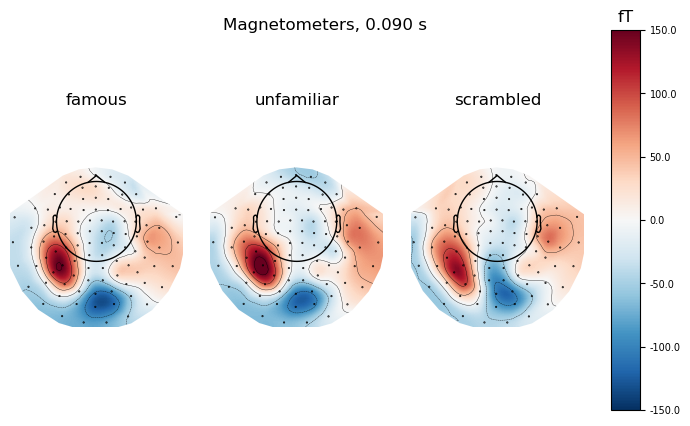

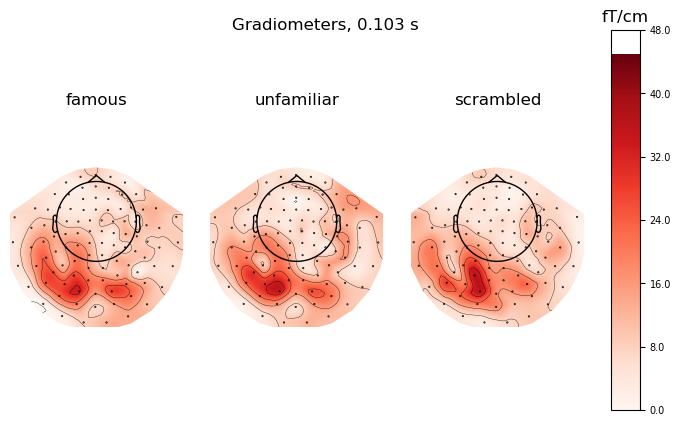

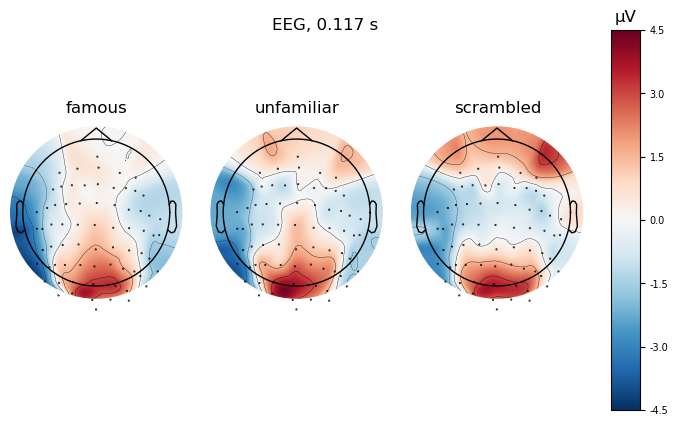

In [39]:
%matplotlib inline
color_lims = [(-150, 150), (0, 45), (-4.5, 4.5)]
channel_types = ['mag', 'grad', 'eeg']
sup_titles = ['Magnetometers', 'Gradiometers', 'EEG']

for ch_type, c_lim, s_title in zip(channel_types, color_lims, sup_titles):

    fig, axes = plt.subplots(1, 4, figsize=(7, 4), gridspec_kw={'width_ratios': [3, 3, 3, 0.5]})
    _, peak_time = evoked.get_peak(ch_type=ch_type, tmax=0.15)

    for ii, (ax, cond) in enumerate(zip(axes, conditions)):
        evokeds_list[ii].plot_topomap(
            ch_type=ch_type, times=peak_time, average=0.1,
            vlim=c_lim, 
            colorbar=(True if ii==2 else False),
            axes=(axes[2::] if ii == 2 else ax), 
            show=False)

        ax.set_title(cond)

    fig.suptitle('%s, %.3f s' % (s_title, peak_time))

## Write evoked data to disk

In [35]:
 # note that the file for evoked ends with -ave.fif
evoked_fname = epochs_fname.replace('-epo.fif', '-ave.fif')
evoked_fname

'/Users/brittawe/Documents/teaching/practical_meeg_2022_data/ds000117/derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-ave.fif'

In [36]:
evoked.save(evoked_fname) 

You can also write multiple conditions into one file:

In [38]:
evoked_list_fname = evoked_fname.replace('-ave.fif', '_list-ave.fif')
mne.write_evokeds(evoked_list_fname, evokeds_list)

### Reading evoked from disk

You can read in the data stored in a `.fif` file:

In [ ]:
evokeds_list = mne.read_evokeds(evoked_fname, baseline=(None, 0), proj=True)

Or give the explicit name of the averaged condition when reading in the list:

In [44]:
evoked_famous = mne.read_evokeds(evoked_list_fname, condition="famous",
                           baseline=(None, 0), proj=True)
evoked_famous

<Evoked | 'famous' (average, N=48), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>

**Remark:** Did you notice that you can apply some preprocessing on reading the evokeds from disk?

## Contrast the conditions

In [ ]:
# now we can use the condition "face", which consists of famous and unfamiliar
evoked_face = epochs['face'].average().apply_proj()
evoked_scrambled = epochs['scrambled'].average().apply_proj()

# adapt the naming
evoked_face.comment = 'face'
evoked_scrambled.comment = 'scrambled'

In [ ]:
contrast = mne.combine_evoked([evoked_face, evoked_scrambled], [0.5, -0.5])

contrast.comment = 'face - scrambled'

Note that this combines evokeds by taking into account the number of averaged epochs (to scale the noise variance). Let's check out the number of epochs we averaged over:

In [ ]:
print(evoked_face.nave) 
print(evoked_scrambled.nave) 
print(contrast.nave) 

95
50
131.03448275862067


In [ ]:
print(contrast)

<Evoked  |  '0.500 * 0.25 * face/famous/first + 0.11 * face/famous/immediate + 0.15 * face/famous/long + 0.26 * face/unfamiliar/first + 0.13 * face/unfamiliar/immediate + 0.11 * face/unfamiliar/long + -0.500 * 0.50 * scrambled/first + 0.28 * scrambled/immediate + 0.22 * scrambled/long' (average, N=131.03448275862067), [-0.5, 2] sec, 376 ch, ~9.8 MB>


Let's plot the contrast together with the ERPs:

/var/folders/5t/zzrvvsdd03721w2g_3y4w8xh0000gn/T/ipykernel_12847/2766748675.py:1: RuntimeWarning: (X, Y) fit (3.1, 32.2) more than 20 mm from head frame origin
  mne.viz.plot_compare_evokeds([evoked_face, evoked_scrambled, contrast], picks='EEG065');


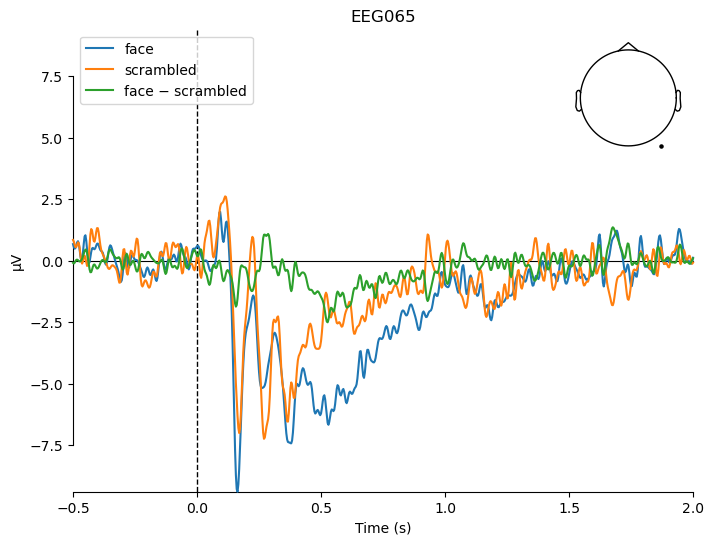

In [ ]:
mne.viz.plot_compare_evokeds([evoked_face, evoked_scrambled, contrast], picks='EEG065');

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Can you plot the difference between famous and unfamiliar faces for an occipital MEG sensor?</li>
    </ul>
</div>


## Plot a 3D field map

We can also plot the topography in 3D. Since MNE-Python also plots the head surface here, we need a `-trans.fif` file, that tells us the _transform_ between the MEG device coordinate system and the head surface coordinate system.

In [ ]:
# get the path of the transform file
# usually, this needs to be created by manual coregistration, but we have it all ready!
trans_file = os.path.join(data_path,
    'derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-trans.fif')

In [ ]:
ls $trans_file

6526.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ls: /Users/brittawe/Documents/teaching/practical_meeg_2022_data/ds000117/derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-trans.fif: No such file or directory
